# Data Cleaning
---
Prepared by Natalie Castro  
CSCI 5832

---

The purpose of this notebook is to clean the Kaggle Sentiment140 dataset for masked language modeling with the task of sentiment prediction. The dataset may be retrieved at [Kaggle's Website](https://www.kaggle.com/datasets/kazanova/sentiment140/data) The dataset's original use was provided for Distance Learning in 2009 from a team at Stanford (Go, Bhayani, Huang: 2009). Sentiment was then defined as a "personal positive or negative feeling". The labels employed for subsequent training were preserved from the original dataset. These labels were generated from 'Twittratr', a website used to generate Tweet analysis with a balanced list of keywords. In addition, the feature reduction techniques presented by the dataset curators were continued in this analysis

**Dataset Characteristics:**
* Emojis were stripped from the data - (Go et al: 2009) provided rationale for this as the classifier would then learn more from the unigram or bigram sets of emoji use instead of the actual meaning of the Tweet - they are "noisy" labels.

* Usernames were replaced with a [username] token. This is to avoid any potential sentiment biases based on the user who is mentioned. 

* URLs were replaced with a [URL] token. This is to ensure that lengthy URLs do not cause for incorrect padding 

* Repeated letters were removed with Regex techniques. The example provided by (Go et al: 2009) illustrated the following example: "huuuungry, huuuuungry, and huuuuuuuuuuungry". Any additional 'u' tokens were replaced with only two occurances. 

**Masking Emotionally Charged Words:**
Twittratr had generated a list of positive and negative words. While not available on Twittratr's current website, these lists were preserved on the Internet Archive. The [positive words](https://web.archive.org/web/20090716125551/http://docs.google.com/Doc?id=df5m8zwp_92gvtfm3d9) and [negative words](https://web.archive.org/web/20090709213341/http://docs.google.com/Doc?id=df5m8zwp_93gd2mhkd7) are linked both here and saved in the project's repository. 

Particular words related to these sentiments will be intentionally masked, at random distributions, in an attempt to increase the preformance of the sentiment classifier. Devlin and colleagues (2019) utilized masked language modeling (also known as the *Cloze* task) to deepen the learning of the model. 15% of the tokens in the input were masked. The following distribution was then followed: 80% the token was replaced with [MASK], 10% of the time the token is replaced with a randomly sampled token from the unigram distribution (Jurafsky and Martin: 2025). 


## 1. Environment Creation

### 1.1 Library Import

In [90]:
''' DATA MANAGEMENT '''
import pandas as pd
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

''' DATA PARSING '''
import regex as re
import string
from collections import Counter

''' DATA MASKING '''
import random

''' DATA VISUALIZATION '''
import seaborn as sb

### 1.2 Dataset Import

In [2]:
data = pd.read_csv("Sentiment140 Twitter Data.csv", encoding='latin-1', names = ['sentiment','tweet_id','date','flag','user','text'])

In [3]:
data.head()

,sentiment,tweet_id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 2. Data Cleaning

### 2.1 Sentiment Labeling

A few different sources online illustrate the ambiguity of the labels - a more illustrative label will be generated for the tweets.

In [4]:
''' EXPLORING THE SENTIMENT VALUES  '''

print (set(data['sentiment'].to_list()))

{0, 4}


In [5]:
''' REMAPPING VALUES '''

## Creating a function to use in a lambda apply 
def label_mapper(x):
    if x == 0:
        return ("Negative")
    
    else:
        return ("Positive")
    

## Applying the function to the dataframe and generating a sentiment label column
data['sentiment label'] = data['sentiment'].copy().apply(lambda x: label_mapper(x))

In [6]:
data.head()

,sentiment,tweet_id,date,flag,user,text,sentiment label
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Negative
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Negative
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Negative
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Negative


In [7]:
test_text = data.at[0, 'text']

In [8]:
test_text

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [9]:
test_text2 = "[USER] He did!   I watched it last night.  Whataaaaa jerk.  I'm sooo not rooting for him anymore!!"

### 2.2 Token Removal

#### 2.2.1 User Tags

In [10]:
''' REPLACING ANY USER TAG WITH [USER] '''

## Defining a RegEx pattern
## This pattern first captures the '@' symbol and any (non)alphanumeric tokens to the next white space
user_pattern = r"(?:@)\w*\W*(?=\s)"
user_token = '[USER]'

## Creating a function intended to be used with a lambda apply
def user_tags(x):
    cleaned_token = re.sub(user_pattern, user_token, x)
    return (cleaned_token)

In [11]:
user_tags(test_text)

"[USER] http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [12]:
## Using lambda apply to replace the 'text' column

data['text'] = data['text'].apply(lambda x: user_tags(x))

#### 2.2.2 URL Removal

In [15]:
''' REPLACING ANY URL TOKEN WITH [URL]'''

## Defining a RegEx pattern
## This pattern identifies any https, http, or any other prefix before a :// indicative of a URL
## Next, it non-greedily searches for any character until the next white space or the end of the string

## The second URL pattern searches for any URLs that may be mentioned by name, but not actual hyperlink.
url_pattern1 = r"\w+://.+?(?=\s|\Z)"
url_pattern2 = r"\S+?(\.com|\.edu|\.org|\.net|\.gov|\.io|\.co|\.uk|\.ca|\.de)(?=\s|\Z)"
url_token = '[URL]'

## Creating a function that replaces any URLs with the defined token
def url_tags(x):
    cleaned_token = re.sub(url_pattern1, url_token, x)
    cleaned_token = re.sub(url_pattern2, url_token, cleaned_token)
    return (cleaned_token)



In [16]:
url_tags("[USER] nawong How do I go about getting access to idzr.org I'm dying to try it out")

"[USER] nawong How do I go about getting access to [URL] I'm dying to try it out"

In [17]:
url_tags(test_text)

"@switchfoot [URL] - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [18]:
## Cleaning the text column

data['text'] = data['text'].apply(lambda x: url_tags(x))

#### 2.2.3 Multiple Character Removal

In [19]:
''' REPLACING MULTIPLE CHARACTERS WITH ONLY TWO '''

## Defining a RegEx pattern
## This pattern identifies any alphanumeric character then 'looks back' twice.
## This pattern will match any consecutive strings of the same number or letter and 'leave' the last two
## Because of this, a RegEx sub for "\1\1" will remove any more than two characters.
multiple_pattern = r"(\w)\1{2,}"
multiple_token = r'\1\1'

## Creating a function that replaces any multiple characters with the defined token
def character_multiplier(x):
    cleaned_token = re.sub(multiple_pattern, multiple_token, x)
    return (cleaned_token)

In [20]:
character_multiplier(test_text)

"@switchfoot http://twitpic.com/2y1zl - Aww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [21]:
## Cleaning the text column 

data['text'] = data['text'].apply(lambda x: character_multiplier(x))

#### 2.2.4 Emoji Removal

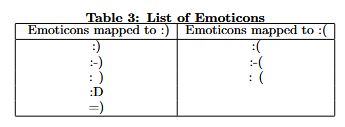
*Citation: Go, Bhayani, Huang: 2009*

Deviating from Go and Colleagues, the emojis will be removed entirely from this dataset. The rationale behind this is driven mainly by the age of the emojis utilized. While in many cases the ':)' emojis are still used, the ubiquity of emojis, emoji combinations, and development over the years - they may mean something completely different than in early social media context. In an attempt to 'translate' the temporal capabilities of the dataset, the emojis were removed. 

Sequentially, removing emojis *after* removing the URLs is important because the ReGEx may pick up on the colon character used in URLs.

In [22]:
''' REMOVING EMOJIS '''
 
## The below pattern is instantiated to remove any emojis in the above table, in addition
## to their winking counterparts. 
emoji_pattern = r"(:|;\))|(:|;-\))|(:|; \))|(:|;D)|(=\))|(:|;\))|(:|;\()|(:|; \()"
emoji_token = ""

## Creating a function to remove the emojis
def emoji_remover(x):
    cleaned_token = re.sub(emoji_pattern, emoji_token, x)
    return (cleaned_token)

In [23]:
emoji_remover(test_text)

"@switchfoot http//twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. "

In [24]:
## Applying the remover to the entire columns

data['text'] = data['text'].apply(lambda x: emoji_remover(x))

### 2.3 Examining Cleaned Text

In [25]:
''' REMOVING DUPLICATES WITH A SUBSET OF TWEET AND SENTIMENT '''

print (f"The length of the original dataset is {len(data)}.\n")
data = data.drop_duplicates(subset=['sentiment label', 'text'])

print (f"The length of the de-duplicated dataset is {len(data)}.")
       

The length of the original dataset is 1600000.

The length of the de-duplicated dataset is 1556582.


In [26]:
tweets = data['text'].to_list()

In [27]:
tweets[6300:6320]

['just gotten out of bed, I hope I start feeling some life in the old girl soon, gonna go and tackle my 16 year olds bedroom in a mo  smell',
 'auuww my mouth is hurting ',
 'just had a mam as talk wif dad bout...shit. [USER] still underhouse arrest. BASICALLY ALL MY TRUST=GONE ',
 'My throat feels like I swallowed a hot coal. ',
 "[USER] yeah, I wasn't expecting that at all  I doubt that's the last we'll hear of it though",
 "Why do my Sprint phones always encounter problems like this around the 6 - 7 month mark??? I'm locked into a 50 yr contract at this point ",
 'My coffee was cold ',
 "Wow, a high of 64 today. I love this weather in Florida. Sadly it won't last long ",
 'Have research report due at five  in the library trying to get it finished',
 "[USER] i'm guessing that was to me, cause these chairs be a pain, but i have no spare powerpoints in my room ",
 "Damn, all my joints are sore at the moment. Either I'm feeling the effects of my PT session, or I'm getting sick, or both.

In [28]:
tweets[10000:10010]

["Snow mounted up to a couple of inches overnight, very pretty but I hope I don't lose my peaches, tree was in bloom ",
 "[USER] Still don't have the confirmation email  Technically I could give up already ",
 '[USER] A tenner?! What a bloody cop out! ',
 '[USER] [URL] - i miss your old hairstyle daniel  but you still look great',
 'Headed 2 a performance...outside...n the rain.  If I do the rain dance backwards will that make it stop? =\\',
 "i wanna get 93841934431984139418349134 dvd's... i hope there is a good dvd store here. im a dvdaholic... and an alcoholic ",
 "i feel ridiculous. and i'm blaming you.  WHY HJSDKFSDHFJSD",
 "everyone is talking about britney's concerts... i want to go ",
 "*yawn* g'mornin' have headache.  pls depart! veggin' w/cuppa chai b4 I have to wrap my head around the day.",
 'Listening to mariah carey we belong together ']

### 2.4 Removing any Duplicates

## 3. Masking

A reminder of the stated masking protocol above:

Devlin and colleagues (2019) utilized masked language modeling (also known as the Cloze task) to deepen the learning of the model. 15% of the tokens in the input were masked. The following distribution was then followed: 80% the token was replaced with [MASK], 20% of the time the token is replaced with a randomly sampled token from the unigram distribution (Jurafsky and Martin: 2025).

### 3.1 Selecting Data to Mask

In [29]:
''' REPORTING ON THE PROPORTIONS OF DATA THAT ARE MASKED '''

dataset_length = len(data)

tokens_to_mask = round(dataset_length * 0.15)

mask_token_amount = round(tokens_to_mask * 0.80)

random_token_amount = round(tokens_to_mask * 0.20)

print (f"TOTAL TWEETS: {dataset_length}\n\nMASKED TWEETS: {tokens_to_mask}\n\nOut of the Masked Tweets...\n\tMASK TOKEN: {mask_token_amount}\n\tRANDOM TOKEN AMOUNT: {random_token_amount}")

TOTAL TWEETS: 1556582

MASKED TWEETS: 233487

Out of the Masked Tweets...
	MASK TOKEN: 186790
	RANDOM TOKEN AMOUNT: 46697


In [30]:
''' SELECTING 233,579 RANDOM TWEETS '''

## Setting the entire population to be the range of the dataset, 
masked_indicies = random.sample(range(dataset_length), tokens_to_mask)

## Creating a list of indicies that are to remain the same
all_indicies = range(dataset_length)
unmasked_indicies = list(set(all_indicies) - set(masked_indicies))


## Filtering the data for masking
masked_data = data.iloc[masked_indicies].copy()
unmasked_data = data.iloc[unmasked_indicies].copy()

## Reseting the dataframe's indicies in place so any sort of .at or 
## query functions will work subsequently
masked_data.reset_index(inplace=True, drop=True)
unmasked_data.reset_index(inplace=True, drop=True)

In [31]:
''' SELECTING 186,863 TWEETS TO MASK'''

mask_token = '[MASK]'

## Generating random indicies from the masked parition
masked_token_indicies = random.sample(range(tokens_to_mask), mask_token_amount)

## Filtering the data for other type of masking
mask_idx = range(mask_token_amount)
random_indicies = list(set(mask_idx) - set(range(random_token_amount)))

## Creating a random replacement dataframe and a mask token replacement frame
masked_tokens_data = masked_data.iloc[masked_token_indicies].copy()
random_tokens_data = masked_data.iloc[random_indicies].copy()

## Resetting the dataframe's indicies
masked_tokens_data.reset_index(inplace=True, drop=True)
random_tokens_data.reset_index(inplace=True, drop=True)

### 3.2 Replacing Tokens with Mask

In [32]:
''' CREATING A RANDOM MASKER WITH RESPECT TO TWEET LENGTH '''

## Creating a RegEx match pattern to split on whitespace
word_pattern = r"\S+"
def masker(x):
    ## Using RegEx findall to generate a list of the words from the tweet
    words = re.findall(word_pattern,x)
   
    ## Identifying the length of the tweet
    tweet_length = len(words)
    
    ## Selecting a random token to mask from the length of the tweet
    token_number = random.sample(range(tweet_length),1)
    
    words[token_number[0]] = '[MASK]'
    
    ## Rejoining the list to form a tweet
    tweet = ' '.join(words)
    
    return (tweet)

In [33]:
masker('Hrm, scanner traffic diminishes greatly when your public services are on strike. ')

'Hrm, scanner traffic diminishes greatly when [MASK] public services are on strike.'

In [34]:
masked_tokens_data['masked text'] = masked_tokens_data['text'].apply(lambda x: masker(x))

In [35]:
''' EXAMINING A FEW OF THE MASKS '''
masked_text = masked_tokens_data['masked text'].to_list()

masked_text[1000:1010]

['At what point in my life did I have to start seriously asking how I get myself checked in? [MASK] I know someone I could ask',
 'I hate [MASK] previews lie.',
 '[MASK] think youre being unfair nathan',
 '[USER] eis [MASK]',
 'LVATT is a trending topic!? Nice Im getting it as soon as target opens, which is at 8 ( Then off to regents [MASK] 9.',
 '[USER] glad [MASK] agree love',
 '[USER] Ah, you just [MASK] to be signed in to view the other one!',
 'just remembered the second reason [MASK] she hated the sun/heat',
 'HeadeD 2 tHe maLL 4 soMe odd reaSon....2 find soMething [MASK]',
 'has just woke up.. what a [MASK] im gettin too old for this']

### 3.3 Replacing Random Tokens with Text Distributions

#### 3.3.1 Identifying the distibution of the Corpus 

In [42]:
''' REPLACING TOKENS WITH RESPECT TO THE POSITIVE OR NEGATIVE WORDS '''

## Positive Words
# Open and read a text file
positive_path = r"C:\Users\natal\OneDrive\university\csci 5832\project\twitrratr positive words.txt"

with open(positive_path, 'r', encoding='utf-8') as file:
    positive_words = file.read()
    positive_words = positive_words.split("\n")

negative_path = r"C:\Users\natal\OneDrive\university\csci 5832\project\twitrrater negative words.txt"

with open(negative_path, 'r', encoding='utf-8') as file:
    negative_words = file.read()
    negative_words = negative_words.split("\n")

In [53]:
word_list = positive_words + negative_words
word_list = list(set(word_list))

In [75]:
''' COMBINING THE ABOVE FUNCTIONS WITH THE MASKER '''

## Creating a RegEx match pattern to split on whitespace
word_pattern = r"\S+"
def random_masker(x):
    ## Using RegEx findall to generate a list of the words from the tweet
    words = re.findall(word_pattern,x)
    
    tweet_length = len(words)
    ## Selecting a random token to mask from the length of the tweet
    token_number = random.sample(range(tweet_length),1)
    
    random_num = random.randint(0, len(word_list))

    words[token_number[0]] = word_list[random_num]
    
    ## Rejoining the list to form a tweet
    tweet = ' '.join(words)
    
    return (tweet)




In [73]:
test_mask = random_tokens_data.at[0, 'text']
test_mask

'Dissertation meeting today - also handing application forms in. Dunno if Kelvingrove is an option today '

In [76]:
random_masker(test_mask)

'Dissertation meeting today - also handing application forms in. Dunno smiling Kelvingrove is an option today'

In [77]:
random_tokens_data['masked text'] = random_tokens_data['text'].apply(lambda x: masker(x))

### 3.   Combining + Saving the Masked Data

In [82]:
unmasked_data['masked text'] = unmasked_data['text']

masked_corpus = pd.concat([unmasked_data,masked_tokens_data,random_tokens_data])
masked_corpus.to_csv("Masked Sentiment140 Dataset.csv")

### 4. Padded Version of the Data

#### 4.1 Tokenizing the Sequences

In [84]:
masked_corpus.head()

,sentiment,tweet_id,date,flag,user,text,sentiment label,masked text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[USER] [URL] - Aww, that's a bummer. You shou...",Negative,"[USER] [URL] - Aww, that's a bummer. You shou..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Negative,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,[USER] I dived many times for the ball. Manage...,Negative,[USER] I dived many times for the ball. Manage...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[USER] no, it's not behaving at all. i'm mad. ...",Negative,"[USER] no, it's not behaving at all. i'm mad. ..."


In [88]:
def sequence_processer(text):
    ## first, converting the string into a list format
    text_ = text.split()
    
    text_storage = []
    ## using the wordnet lemmatizer to lemmatize the words
    for word in text_:
        lemma = lemmatizer.lemmatize(word)
        text_storage.append(lemma)
        
    ## removing all of the punctuation, special characters, digits, and trailing spaces using RegEx
    text_for_cleaning = ' '.join(text_storage)
    clean_text = re.sub('[!@#$%^&*()_+\'",.?*-+:;<>~`0-9]',' ',text_for_cleaning)
    stripped_text = clean_text.strip()
    
    ##splitting the string back into a list 
    preprocessed_text = stripped_text.split()
    
    ## returning the the final processed text
    return (preprocessed_text)

In [91]:
masked_corpus['listed text'] = masked_corpus['masked text'].apply (lambda x: sequence_processer(x))

In [92]:
''' INDEXING THE TOKENS '''
# Make a token2index dictionary and a index2token dictionary and convert the documents to sequences of indices
token2index = {}
index2token = {}
saved_tokens = []
index = 1 # reserve 0 for padding
for document in masked_corpus['listed text'].to_list():
    for token in document:

        ## checking to see if the token is currently in the list of keys 
        if token in saved_tokens:
        ## if it is pass
            pass
        
        ## if the token is not currently in the list of keys
        if token not in saved_tokens:
            ## saving the token to iterate through
            saved_tokens.append(token)
            ## create a new key in the dictionary and adding the index
            token2index[token] = index
            ## adding one to the index
            index = index + 1
            
## once the disctionary has been generated, converting the token2index to the index2token dictionary
index2token = {k:v for k,v in zip(token2index.values(),token2index.keys())}

token2index['[PAD]'] = 0
index2token[0] = '[PAD]'

print(f'Number of unique tokens: {len(token2index)}')

Number of unique tokens: 388063


In [93]:
# Convert the dataset into sequences of indices
def document_to_sequence(document : str) -> list:
    return [token2index[token] for token in document]

In [95]:
sequences = masked_corpus['listed text'].apply(document_to_sequence)
print(sequences.head()) # should now be a list of indices

0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
1    [20, 21, 5, 22, 23, 24, 25, 26, 27, 28, 29, 19...
2    [1, 38, 39, 40, 41, 42, 43, 44, 45, 17, 46, 47...
3             [52, 53, 54, 55, 56, 30, 57, 19, 58, 59]
4    [1, 60, 19, 6, 61, 62, 63, 64, 65, 66, 67, 68,...
Name: listed text, dtype: object


#### 4.2 Padding the Sequences

In [110]:
# Truncate the sequences
def pad_sequence(sequence: list, max_length: int, padding_token: int = 0) -> list:
    ## checking to see the length of the token 
    sequence_length = len(sequence)
    #print (sequence)
    #print (sequence_length)
    
    ## creating an if / else statement to check if it is above or below with the length.
    if sequence_length >= max_length:
        ## if the sequence length is above, it is truncated and only the first n for the max sequence are returned
        truncated_sequence = sequence[0:max_length]
        
        return (truncated_sequence)

    ## else: the pad token is appended onto the end until it is the max sequence
    else:
        
        ## finds the difference between the length of the sequence and the max length
        difference = max_length - sequence_length
 
        # generating a list with the length of the difference
        padded_list = ['[PAD]'] * difference
   
        ## extending the sequence with the pad values
        padded_sequence = sequence + padded_list
        ## returning the list
        return (padded_sequence)

In [111]:
# Maximum sequence length
max_length = 40

# Truncate the sequences
truncated_sequences = sequences.apply(lambda x: pad_sequence(x, max_length))

print(truncated_sequences.head())

0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
1    [20, 21, 5, 22, 23, 24, 25, 26, 27, 28, 29, 19...
2    [1, 38, 39, 40, 41, 42, 43, 44, 45, 17, 46, 47...
3    [52, 53, 54, 55, 56, 30, 57, 19, 58, 59, [PAD]...
4    [1, 60, 19, 6, 61, 62, 63, 64, 65, 66, 67, 68,...
Name: listed text, dtype: object


In [118]:
truncated_sequences.reset_index(inplace=True, drop = True)

In [120]:
sequences.reset_index(inplace=True, drop = True)

In [116]:
masked_corpus.reset_index(inplace=True, drop = True)

In [121]:
masked_corpus['truncated sequences'] = truncated_sequences
masked_corpus['tokenized sequences'] = sequences

In [122]:
print(masked_corpus.at[1649977, 'listed text'])
print(masked_corpus.at[1649977, 'truncated sequences'])
print(masked_corpus.at[1649977, 'tokenized sequences'])

['[USER]', 'how', '[MASK]', 'doin']
[1, 88, 353990, 9618, '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 88, 353990, 9618, '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [124]:
masked_corpus.to_csv('Cleaned Sentiment140 Dataset with Tokenized Sequences.csv')

In [123]:
masked_corpus

,sentiment,tweet_id,date,flag,user,text,sentiment label,masked text,listed text,truncated sequences,tokenized sequences
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[USER] [URL] - Aww, that's a bummer. You shou...",Negative,"[USER] [URL] - Aww, that's a bummer. You shou...","[[USER], [URL], -, Aww, that, s, a, bummer, Yo...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Negative,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can, t, update, his, Fac...","[20, 21, 5, 22, 23, 24, 25, 26, 27, 28, 29, 19...","[20, 21, 5, 22, 23, 24, 25, 26, 27, 28, 29, 19..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,[USER] I dived many times for the ball. Manage...,Negative,[USER] I dived many times for the ball. Manage...,"[[USER], I, dived, many, time, for, the, ball,...","[1, 38, 39, 40, 41, 42, 43, 44, 45, 17, 46, 47...","[1, 38, 39, 40, 41, 42, 43, 44, 45, 17, 46, 47..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative,my whole body feels itchy and like its on fire,"[my, whole, body, feel, itchy, and, like, it, ...","[52, 53, 54, 55, 56, 30, 57, 19, 58, 59, [PAD]...","[52, 53, 54, 55, 56, 30, 57, 19, 58, 59, [PAD]..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[USER] no, it's not behaving at all. i'm mad. ...",Negative,"[USER] no, it's not behaving at all. i'm mad. ...","[[USER], no, it, s, not, behaving, at, all, i,...","[1, 60, 19, 6, 61, 62, 63, 64, 65, 66, 67, 68,...","[1, 60, 19, 6, 61, 62, 63, 64, 65, 66, 67, 68,..."
...,...,...,...,...,...,...,...,...,...,...,...
1649973,0,2175233627,Mon Jun 15 00:26:02 PDT 2009,NO_QUERY,babbittry,Can't switch to sprint....no palm pre...,Negative,Can't [MASK] to sprint....no palm pre...,"[Can, t, [MASK], to, sprint, no, palm, pre]","[698, 24, 353990, 17, 869, 60, 9068, 2100, [PA...","[698, 24, 353990, 17, 869, 60, 9068, 2100, [PA..."
1649974,4,2070543008,Sun Jun 07 17:52:58 PDT 2009,NO_QUERY,jeremyrbennett,[USER] you should be at youth group!!!! --R...,Positive,[USER] you should be at [MASK] group!!!! --Roc...,"[[USER], you, should, be, at, [MASK], group, -...","[1, 73, 557, 418, 63, 353990, 2950, 388061, 38...","[1, 73, 557, 418, 63, 353990, 2950, 388061, 38..."
1649975,4,1974202139,Sat May 30 12:38:50 PDT 2009,NO_QUERY,Pwiimus,"[USER] Stavros Flatly, you know it makes sense",Positive,"[USER] [MASK] Flatly, you know it makes sense","[[USER], [MASK], Flatly, you, know, it, make, ...","[1, 353990, 90627, 73, 269, 19, 214, 3669, [PA...","[1, 353990, 90627, 73, 269, 19, 214, 3669, [PA..."
1649976,4,2054221301,Sat Jun 06 06:51:36 PDT 2009,NO_QUERY,marshymiffy,[USER] Aww! you're welcome!,Positive,[USER] Aww! [MASK] welcome!,"[[USER], Aww, [MASK], welcome]","[1, 4, 353990, 5898, [PAD], [PAD], [PAD], [PAD...","[1, 4, 353990, 5898, [PAD], [PAD], [PAD], [PAD..."


---

#### Bibliography

Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (No. arXiv:1810.04805). arXiv. http://arxiv.org/abs/1810.04805


Go, A., Bhayani, R., & Huang, L. (2009). Twitter Sentiment Classiﬁcation using Distant Supervision. CS224N Project Report.

Jurafsky, D., & Martin, J. (2025). Speech and Language Processing (3rd ed.). https://web.stanford.edu/~jurafsky/slp3/ed3book_Jan25.pdf

